## Stationarity Analysis

#### FFT Window/Overlap sweep

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

homedir = '/home/pedrolisboa'
from itertools import product
sys.path.extend([os.path.join(homedir, 'Workspace', 'lps', 'LpsToolbox')])
from Functions.FunctionsDataVisualization import plotScores
from Functions.CrossValidation import SonarRunsCV
from Functions.DataHandler import LofarDataset
from Functions.NpUtils.DataTransformation import SonarRunsInfo, lofar2image
from lps_toolbox.neural_network.classifiers import ConvNetClassifier
from Functions.SonarFunctions.read_raw_data import AudioData
from Functions.SonarFunctions.lofar_analysis import LofarAnalysis
from Functions.NpUtils.DataTransformation import SonarRunsInfo, lofar2image


from vis_functions import plot_sp_by_spectres

sns.set_style('whitegrid')
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.numpoints'] = 1
plt.rc('legend', **{'fontsize': 15})
plt.rc('font', weight='bold')

datapath = os.getenv('OUTPUTDATAPATH')
audiodatapath = os.getenv('INPUTDATAPATH')
results_path = os.getenv('PACKAGE_NAME')
database = '4classes'

sns.set_color_codes()

Using TensorFlow backend.


### Data summary
---

In [2]:
dict_results = {'10': pd.read_csv('results_10_windows.csv').drop('Unnamed: 0', axis=1),
                '15': pd.read_csv('results_15_windows.csv').drop('Unnamed: 0', axis=1),
                '20': pd.read_csv('results_20_windows.csv').drop('Unnamed: 0', axis=1),
                '25': pd.read_csv('results_25_windows.csv').drop('Unnamed: 0', axis=1),
                '30': pd.read_csv('results_30_windows.csv').drop('Unnamed: 0', axis=1)}
for key in dict_results.keys():
    dict_results[key]['Window Qtd'] = int(key)
    
# dict_results['10']['sp'] = dict_results['10']['scores']
df_results = pd.concat(dict_results.values(), axis=0, sort=True)
del dict_results
#df_results = df_results.set_index(keys=['Window Qtd', 'decimation', 'fold', 'novelty', 'overlap', 'window'])

In [3]:
old_10 = pd.read_csv('../Backup/results_10.csv')
df_results.loc[(df_results.window == 4096) &\
               (df_results.overlap == 0) &\
               (df_results['Window Qtd'] == 10) &\
               (df_results.decimation == 1),'sp'] = old_10.loc[(old_10.window == 4096),'scores'].values
df_results.loc[(df_results.window == 2048) &\
               (df_results.overlap == 0) &\
               (df_results['Window Qtd'] == 10) &\
               (df_results.decimation == 1),'sp'] = old_10.loc[(old_10.window == 2048),'scores'].values

df_results.loc[df_results.overlap != 0, 'overlap'] = 50
df_results = df_results.set_index(keys=['Window Qtd', 'decimation', 'fold', 'novelty', 'overlap', 'window'])

In [247]:
adf_pts = [20.0, 43.0, 72.0, 88.0, 96.0, 99.9, 99.9]
pp_pts =  [21.0, 43.5, 72.3, 87.0, 95.8, 99.9, 99.9]

jr_data = dict(ClassA = dict(mean = [71.5, 73.4, 83.5, 88.5, 90.4, 82.4, 50.4],
                               std  = [02.0, 00.8, 01.0, 02.0, 01.5, 00.9, 00.5]),

               ClassB = dict(mean = [68.5, 71.4, 77.5, 84.2, 86.7, 82.4, 60.4],
                               std = [04.0, 02.1, 01.0, 02.0, 01.5, 00.9, 01.5]),

               ClassC = dict(mean=[73.1, 74.4, 76.5, 81.2, 87.7, 79.4, 61.4],
                     std=[06.0, 02.1, 01.0, 02.0, 01.5, 01.0, 01.5]),

               ClassD = dict(mean=[70.5, 77.1, 81.5, 88.2, 90.7, 80.4, 70.4],
                     std=[04.0, 02.1, 01.0, 02.0, 01.5, 00.9, 01.5]))

# Transform the data to insert into seaborn plot
n_folds = 10
window_list = [128, 256, 512, 1024, 2048, 4096, 8192]
from itertools import cycle
window_length = cycle(range(0, len(window_list)))
data_new_format = {'window' : np.concatenate([np.repeat(w, n_folds) for w in window_list]),
                   'fold': np.concatenate([np.arange(0,n_folds) for _ in window_list]),
                   'novelty': np.concatenate([np.repeat(0, len(window_list)*n_folds),
                                              np.repeat(1, len(window_list)*n_folds),
                                              np.repeat(2, len(window_list)*n_folds),
                                              np.repeat(3, len(window_list)*n_folds)])} 

x = np.zeros(n_folds*len(window_list))
for key in jr_data:
    for i, (fold, window) in enumerate(zip(data_new_format['fold'], data_new_format['window'])):
        mean = jr_data[key]['mean']
        std = jr_data[key]['std']
        x[i] = mean[window_length.next()]
        
            if i % 2 == 0:
                x[i] += std[window_length.next()]
            else:
                x[i] -= std[window_length.next()]
data_new_format['scores'] = x 

data_new_format

IndentationError: unexpected indent (<ipython-input-247-d489105b4cc3>, line 35)

### Classification Efficiency: 
#### Image with 10 spectres -- FFT: 1024 points / 0% overlap
---

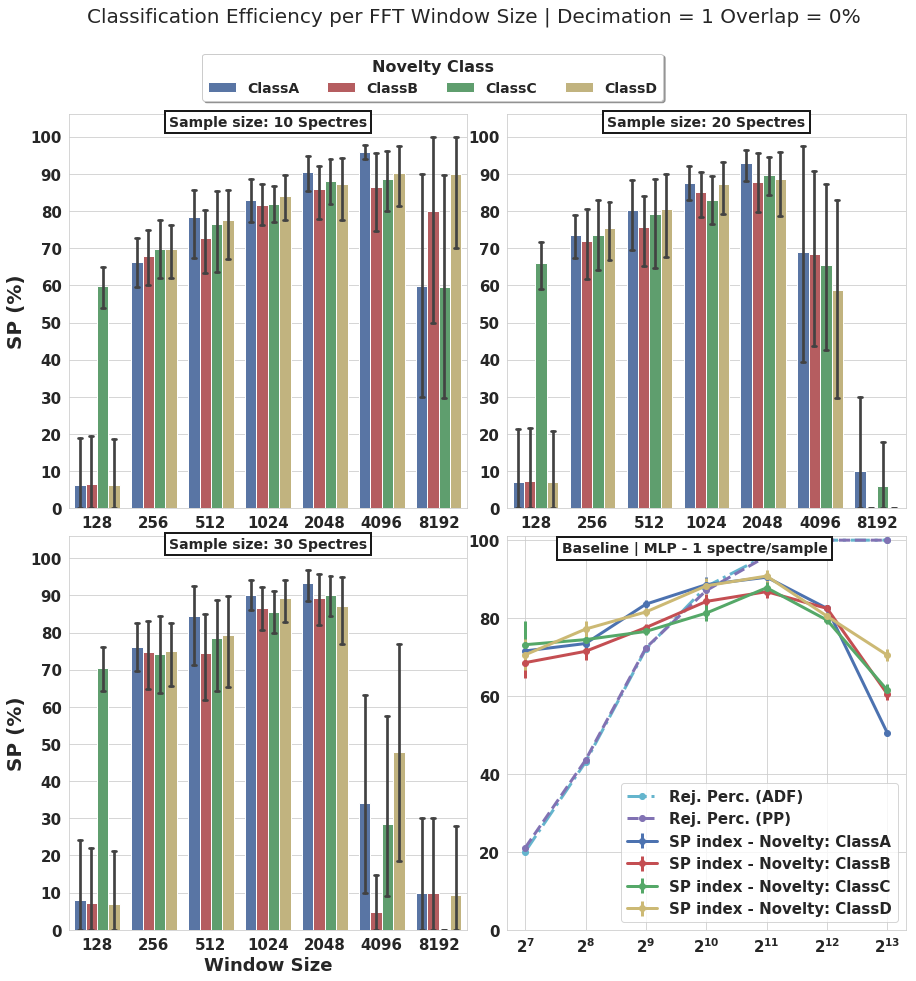

In [15]:
%matplotlib inline
qtd=10; decimation=1; overlap=0
fig, axes = plt.subplots(figsize=(15,15), nrows=2, ncols=2)

for i_ax, ax in enumerate(axes.flatten()):
    if i_ax == 3:
        adf_pts = [20.0, 43.0, 72.0, 88.0, 96.0, 99.9, 99.9]
        pp_pts = [21.0, 43.5, 72.3, 87.0, 95.8, 99.9, 99.9]

        window_size = [128, 256, 512, 1024, 2048, 4096, 8192]


        line_width = 3.0
        m_leg = []

        sp_mean_pts = [71.5, 73.4, 83.5, 88.5, 90.4, 82.4, 50.4]
        sp_var_pts =  [02.0, 00.8, 01.0, 02.0, 01.5, 00.9, 00.5]

        ax.errorbar(window_size, sp_mean_pts, sp_var_pts, 
                     marker='o', color='b', linewidth=line_width, label='SP index - Novelty: ClassA')
        #m_leg.append('SP index (NN)')

        sp_mean_pts = [68.5, 71.4, 77.5, 84.2, 86.7, 82.4, 60.4]
        sp_var_pts =  [04.0, 02.1, 01.0, 02.0, 01.5, 00.9, 01.5]

        ax.errorbar(window_size, sp_mean_pts, sp_var_pts, 
                     marker='o', color='r', linewidth=line_width, label='SP index - Novelty: ClassB')

        sp_mean_pts = [73.1, 74.4, 76.5, 81.2, 87.7, 79.4, 61.4]
        sp_var_pts =  [06.0, 02.1, 01.0, 02.0, 01.5, 01.0, 01.5]

        ax.errorbar(window_size, sp_mean_pts, sp_var_pts, 
                     marker='o', color='g', linewidth=line_width, label='SP index - Novelty: ClassC')

        sp_mean_pts = [70.5, 77.1, 81.5, 88.2, 90.7, 80.4, 70.4]
        sp_var_pts =  [04.0, 02.1, 01.0, 02.0, 01.5, 00.9, 01.5]

        ax.errorbar(window_size, sp_mean_pts, sp_var_pts, 
                     marker='o', color='y', linewidth=line_width, label='SP index - Novelty: ClassD')

        ax.semilogx(window_size, adf_pts, basex=2, 
                     marker='o', color='c', linewidth=line_width, 
                     ls='-.', label='Rej. Perc. (ADF)')
        #m_leg.append('Rej. Perc. (ADF)')

        ax.semilogx(window_size, pp_pts, basex=2, 
                     marker='o', color='m', linewidth=line_width,
                    ls='--',label='Rej. Perc. (PP)')
        
        ax.set_xticks(window_size)
        #m_leg.append('Rej. Perc. (PP)')
        ax.set_ylim(0,101)

        ax.legend(loc='best')

        #plt.grid()

        xticks = [64,128, 256, 512, 1024, 2048, 4096, 8192,8192*2]

        #ax.xticks(xticks,rotation=45)

#         ax.set_title('Baseline - MLP', fontsize=18, fontweight='bold')
        #plt.xlabel('Window Size',fontsize=18, fontweight='bold')
        #plt.ylabel('SP index -- Rej. Perc.',fontsize=18, fontweight='bold')
        bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="k", lw=2)
        t = ax.text(895.0, 96, "Baseline | MLP - 1 spectre/sample", ha="center", va="bottom", 
                size=14,
                bbox=bbox_props)
        continue
#     if i_ax==3:
#         continue
    i_qtd = (i_ax+1)*qtd
    xs_results = df_results.xs(decimation, level='decimation')\
                           .xs(overlap, level='overlap', drop_level=True)\
                           .xs(i_qtd, level='Window Qtd')
    xs_results.reset_index(level=['window', 'novelty'], drop=False, inplace=True)
    xs_results.drop(['eff_0', 'eff_1', 'eff_2'], axis=1, inplace=True)
    xs_results.loc[:, 'sp'] = 100*xs_results.loc[:, 'sp'].values
    sns.barplot(x='window', y='sp', hue='novelty', data=xs_results, 
                  #palette={0:'b', 1:'g', 2:'y', 4:'r'},
                  palette=['b', 'r', 'g', 'y'],
                  capsize=0.07,
                  dodge=-0.2, ax=ax)
    if i_ax // 2 != 0:
        ax.set_xlabel('Window Size', fontsize=18, weight='bold')
    else:
        ax.set_xlabel('', fontsize=1, weight='bold')
    if i_ax % 2 == 0:
        ax.set_ylabel('SP (%)', fontsize=20, weight='bold')
    else:
        ax.set_ylabel('', fontsize=1, weight='bold')
    ax.set_ylim(0,106)
    ax.set_yticks([i for i in range(0,110,10)])
    leg_handles = ax.get_legend_handles_labels()[0]
#     ax.set_title('%i Spectres' % (i_qtd), fontsize=20)
    
    bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="k", lw=2)
    t = ax.text(3.0, 102, "Sample size: %i Spectres" % i_qtd, ha="center", va="bottom", 
                size=14,
                bbox=bbox_props)
    
    if i_ax == 1:
        legend = ax.legend(handles=leg_handles,
                           bbox_to_anchor=(-0.8,1.19),
                           ncol=4,
                           labels=['ClassA', 'ClassB', 'ClassC', 'ClassD'],
                           #mode="expand",
                           borderaxespad=1.0,
                           shadow=True,
                           frameon=True,
                           fancybox=True,
                           title='Novelty Class',
                           fontsize=14,
                           loc='upper left')
        legend.get_title().set_fontsize(16)
    else:
        ax.get_legend().set_visible(False)
    
    
fig.subplots_adjust(wspace=0.1, hspace=0.07)
fig.suptitle('Classification Efficiency per FFT Window Size |' 
             ' Decimation = 1 Overlap = 0%', fontsize=20);
fig.savefig('geral_dec_1.png', dpi = 300, bbox_inches='tight')

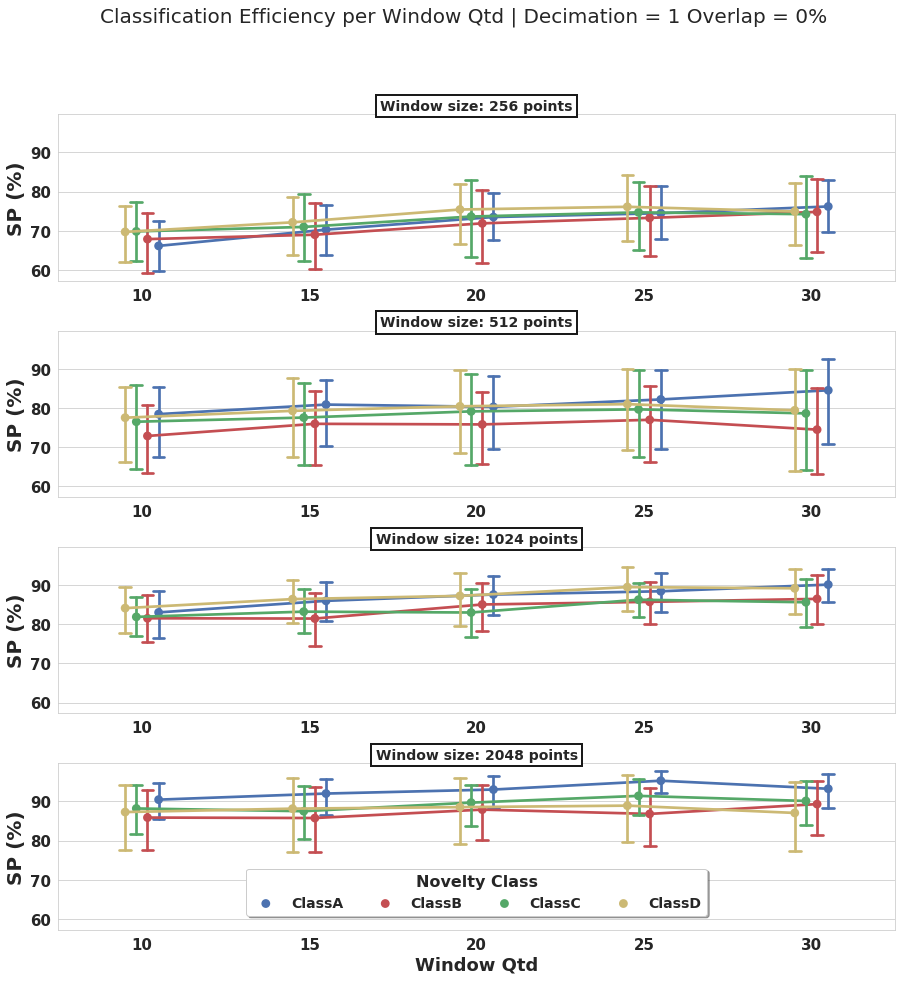

In [16]:
%matplotlib inline
qtd=256; decimation=1; overlap=0
fig, axes = plt.subplots(figsize=(15,15), nrows=4, ncols=1, sharey=True)

for i_ax, ax in enumerate(axes.flatten()):
    i_qtd = pow(2,i_ax)*qtd
    xs_results = df_results.xs(decimation, level='decimation')\
                           .xs(overlap, level='overlap', drop_level=True)\
                           .xs(i_qtd, level='window')
    xs_results.reset_index(level=['Window Qtd', 'novelty'], drop=False, inplace=True)
    xs_results.drop(['eff_0', 'eff_1', 'eff_2'], axis=1, inplace=True)
    xs_results.loc[:, 'sp'] = 100*xs_results.loc[:, 'sp'].values
    sns.pointplot(x='Window Qtd', y='sp', hue='novelty', data=xs_results, 
                  #palette={0:'b', 1:'g', 2:'y', 4:'r'},
                  palette=['b', 'r', 'g', 'y'],
                  capsize=0.07,
                  dodge=-0.2, ax=ax)
    if i_ax == 3:
        ax.set_xlabel('Window Qtd', fontsize=18, weight='bold')
    else:
        ax.set_xlabel('', fontsize=1, weight='bold')
    ax.set_ylabel('SP (%)', fontsize=20, weight='bold')

    leg_handles = ax.get_legend_handles_labels()[0]
#     ax.set_title('%i Spectres' % (i_qtd), fontsize=20)
    
    bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="k", lw=2)
    t = ax.text(2.0, 100, "Window size: %i points" % i_qtd, ha="center", va="bottom", 
                size=14,
                bbox=bbox_props)
    
    if i_ax == 3:
        legend = ax.legend(handles=leg_handles,
                           #bbox_to_anchor=(-0.8,1.19),
                           ncol=4,
                           labels=['ClassA', 'ClassB', 'ClassC', 'ClassD'],
                           #mode="expand",
                           borderaxespad=1.0,
                           shadow=True,
                           frameon=True,
                           fancybox=True,
                           title='Novelty Class',
                           fontsize=14,
                           loc='lower center')
        legend.get_title().set_fontsize(16)
    else:
        ax.get_legend().set_visible(False)
fig.subplots_adjust(hspace=0.30)
fig.suptitle('Classification Efficiency per Window Qtd |' 
             ' Decimation = 1 Overlap = 0%', fontsize=20);
fig.savefig('geral_dec_1.png', dpi = 300, bbox_inches='tight')

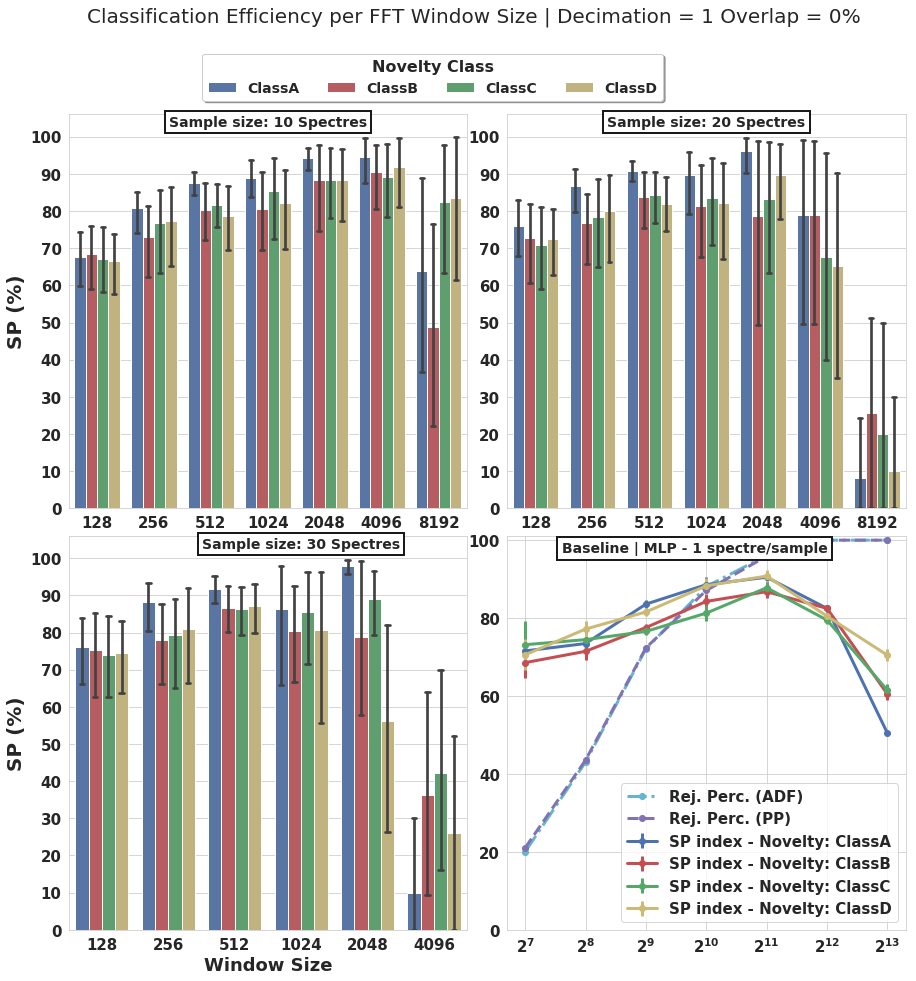

In [17]:
%matplotlib inline
qtd=10; decimation=3; overlap=0
fig, axes = plt.subplots(figsize=(15,15), nrows=2, ncols=2)

for i_ax, ax in enumerate(axes.flatten()):
    if i_ax == 3:
        adf_pts = [20.0, 43.0, 72.0, 88.0, 96.0, 99.9, 99.9]
        pp_pts = [21.0, 43.5, 72.3, 87.0, 95.8, 99.9, 99.9]

        window_size = [128, 256, 512, 1024, 2048, 4096, 8192]


        line_width = 3.0
        m_leg = []

        sp_mean_pts = [71.5, 73.4, 83.5, 88.5, 90.4, 82.4, 50.4]
        sp_var_pts =  [02.0, 00.8, 01.0, 02.0, 01.5, 00.9, 00.5]

        ax.errorbar(window_size, sp_mean_pts, sp_var_pts, 
                     marker='o', color='b', linewidth=line_width, label='SP index - Novelty: ClassA')
        #m_leg.append('SP index (NN)')

        sp_mean_pts = [68.5, 71.4, 77.5, 84.2, 86.7, 82.4, 60.4]
        sp_var_pts =  [04.0, 02.1, 01.0, 02.0, 01.5, 00.9, 01.5]

        ax.errorbar(window_size, sp_mean_pts, sp_var_pts, 
                     marker='o', color='r', linewidth=line_width, label='SP index - Novelty: ClassB')

        sp_mean_pts = [73.1, 74.4, 76.5, 81.2, 87.7, 79.4, 61.4]
        sp_var_pts =  [06.0, 02.1, 01.0, 02.0, 01.5, 01.0, 01.5]

        ax.errorbar(window_size, sp_mean_pts, sp_var_pts, 
                     marker='o', color='g', linewidth=line_width, label='SP index - Novelty: ClassC')

        sp_mean_pts = [70.5, 77.1, 81.5, 88.2, 90.7, 80.4, 70.4]
        sp_var_pts =  [04.0, 02.1, 01.0, 02.0, 01.5, 00.9, 01.5]

        ax.errorbar(window_size, sp_mean_pts, sp_var_pts, 
                     marker='o', color='y', linewidth=line_width, label='SP index - Novelty: ClassD')

        ax.semilogx(window_size, adf_pts, basex=2, 
                     marker='o', color='c', linewidth=line_width, 
                     ls='-.', label='Rej. Perc. (ADF)')
        #m_leg.append('Rej. Perc. (ADF)')

        ax.semilogx(window_size, pp_pts, basex=2, 
                     marker='o', color='m', linewidth=line_width,
                    ls='--',label='Rej. Perc. (PP)')
        
        ax.set_xticks(window_size)
        #m_leg.append('Rej. Perc. (PP)')
        ax.set_ylim(0,101)

        ax.legend(loc='best')

        #plt.grid()

        xticks = [64,128, 256, 512, 1024, 2048, 4096, 8192,8192*2]

        #ax.xticks(xticks,rotation=45)

#         ax.set_title('Baseline - MLP', fontsize=18, fontweight='bold')
        #plt.xlabel('Window Size',fontsize=18, fontweight='bold')
        #plt.ylabel('SP index -- Rej. Perc.',fontsize=18, fontweight='bold')
        bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="k", lw=2)
        t = ax.text(895.0, 96, "Baseline | MLP - 1 spectre/sample", ha="center", va="bottom", 
                size=14,
                bbox=bbox_props)
        continue
#     if i_ax==3:
#         continue
    i_qtd = (i_ax+1)*qtd
    xs_results = df_results.xs(decimation, level='decimation')\
                           .xs(overlap, level='overlap', drop_level=True)\
                           .xs(i_qtd, level='Window Qtd')
    xs_results.reset_index(level=['window', 'novelty'], drop=False, inplace=True)
    xs_results.drop(['eff_0', 'eff_1', 'eff_2'], axis=1, inplace=True)
    xs_results.loc[:, 'sp'] = 100*xs_results.loc[:, 'sp'].values
    sns.barplot(x='window', y='sp', hue='novelty', data=xs_results, 
                  #palette={0:'b', 1:'g', 2:'y', 4:'r'},
                  palette=['b', 'r', 'g', 'y'],
                  capsize=0.07,
                  dodge=-0.2, ax=ax)
    if i_ax // 2 != 0:
        ax.set_xlabel('Window Size', fontsize=18, weight='bold')
    else:
        ax.set_xlabel('', fontsize=1, weight='bold')
    if i_ax % 2 == 0:
        ax.set_ylabel('SP (%)', fontsize=20, weight='bold')
    else:
        ax.set_ylabel('', fontsize=1, weight='bold')
    ax.set_ylim(0,106)
    ax.set_yticks([i for i in range(0,110,10)])
    leg_handles = ax.get_legend_handles_labels()[0]
#     ax.set_title('%i Spectres' % (i_qtd), fontsize=20)
    
    bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="k", lw=2)
    t = ax.text(3.0, 102, "Sample size: %i Spectres" % i_qtd, ha="center", va="bottom", 
                size=14,
                bbox=bbox_props)
    s
    if i_ax == 1:
        legend = ax.legend(handles=leg_handles,
                           bbox_to_anchor=(-0.8,1.19),
                           ncol=4,
                           labels=['ClassA', 'ClassB', 'ClassC', 'ClassD'],
                           #mode="expand",
                           borderaxespad=1.0,
                           shadow=True,
                           frameon=True,
                           fancybox=True,
                           title='Novelty Class',
                           fontsize=14,
                           loc='upper left')
        legend.get_title().set_fontsize(16)
    else:
        ax.get_legend().set_visible(False)
    
    
fig.subplots_adjust(wspace=0.1, hspace=0.07)
fig.suptitle('Classification Efficiency per FFT Window Size |' 
             ' Decimation = 1 Overlap = 0%', fontsize=20);
fig.savefig('geral_dec_3.png', dpi = 300, bbox_inches='tight')

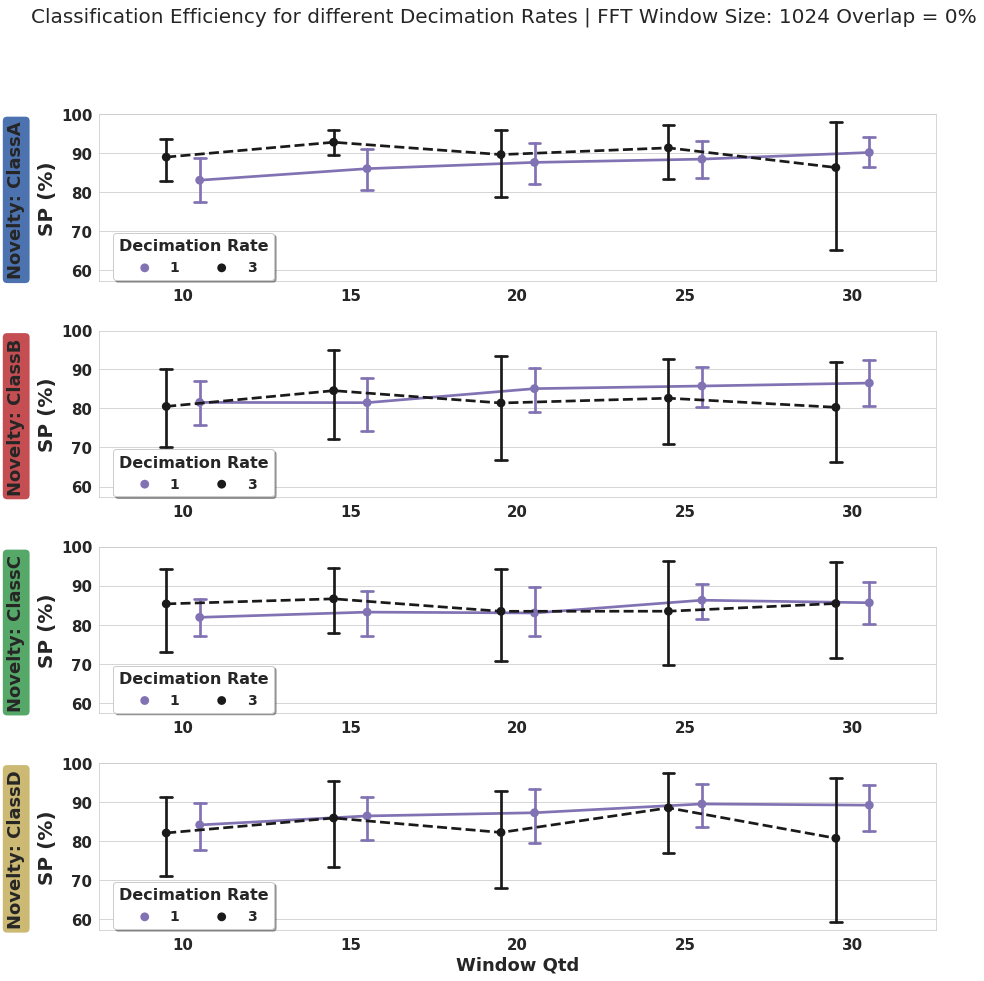

In [18]:
%matplotlib inline
qtd=1024; decimation=1; overlap=0
fig, axes = plt.subplots(figsize=(15,15), nrows=4, ncols=1, sharey=True)

for i_ax, ax in enumerate(axes.flatten()):
    nv = i_ax
    xs_results = df_results.xs(overlap, level='overlap', drop_level=True)\
                           .xs(qtd, level='window')\
                           .xs(nv, level='novelty')
    xs_results.reset_index(level=['Window Qtd', 'decimation'], drop=False, inplace=True)
    xs_results.drop(['eff_0', 'eff_1', 'eff_2'], axis=1, inplace=True)
    xs_results.loc[:, 'sp'] = 100*xs_results.loc[:, 'sp'].values
    sns.pointplot(x='Window Qtd', y='sp', hue='decimation', data=xs_results, 
                  #palette={0:'b', 1:'g', 2:'y', 4:'r'},
                  palette=['m', 'k'],
                  linestyles=['-', '--'],
                  capsize=0.07,
                  dodge=-0.2, ax=ax)
    if i_ax == 3:
        ax.set_xlabel('Window Qtd', fontsize=18, weight='bold')
    else:
        ax.set_xlabel('', fontsize=1, weight='bold')
    ax.set_ylabel('SP (%)', fontsize=20, weight='bold')

    leg_handles = ax.get_legend_handles_labels()[0]
#     ax.set_title('%i Spectres' % (i_qtd), fontsize=20)
    class_map = ['ClassA', 'ClassB', 'ClassC', 'ClassD']
    color_map = {0:'b',1:'r',2:'g',3:'y'}
    bbox_props = dict(boxstyle="round,pad=0.3", fc=color_map[nv], ec="w", lw=2)
    t = ax.text(-1.05, 78, "Novelty: %s" % class_map[nv], ha="left", va="center", rotation=90,
                size=18,
                bbox=bbox_props)
    
    #if i_ax == 0:
    legend = ax.legend(handles=leg_handles,
                       bbox_to_anchor=(0.00,-0.080),
                       ncol=2,
                       #labels=['3', '1'],
                       #mode="expand",
                       borderaxespad=1.0,
                       shadow=True,
                       frameon=True,
                       fancybox=True,
                       title='Decimation Rate',
                       fontsize=14,
                       loc='lower left')
    legend.get_title().set_fontsize(16)
    #else:
    #    ax.get_legend().set_visible(False)
fig.subplots_adjust(hspace=0.30)
fig.suptitle('Classification Efficiency for different Decimation Rates |' 
             ' FFT Window Size: 1024 Overlap = 0%', fontsize=20);
fig.savefig('dec_run_1024.png', dpi = 300, bbox_inches='tight')

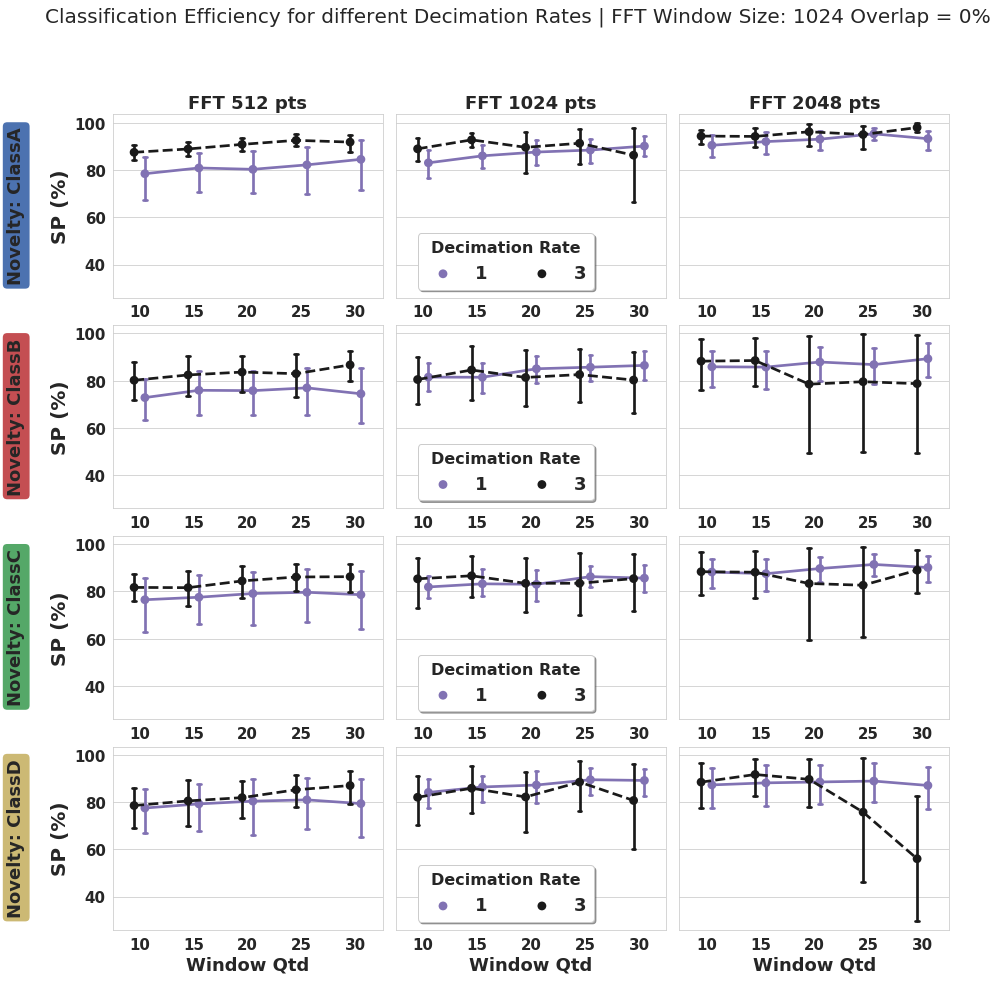

In [20]:
%matplotlib inline
qtd_list=[512,1024,2048]; decimation=1; overlap=0
fig, axes = plt.subplots(figsize=(15,15), nrows=4, ncols=3, sharey=True)
for i, qtd in enumerate(qtd_list):
    for i_ax, ax in enumerate(axes[:,i]):
        nv = i_ax
        xs_results = df_results.xs(overlap, level='overlap', drop_level=True)\
                               .xs(qtd, level='window')\
                               .xs(nv, level='novelty')
        xs_results.reset_index(level=['Window Qtd', 'decimation'], drop=False, inplace=True)
        xs_results.drop(['eff_0', 'eff_1', 'eff_2'], axis=1, inplace=True)
        xs_results.loc[:, 'sp'] = 100*xs_results.loc[:, 'sp'].values
        sns.pointplot(x='Window Qtd', y='sp', hue='decimation', data=xs_results, 
                      #palette={0:'b', 1:'g', 2:'y', 4:'r'},
                      palette=['m', 'k'],
                      linestyles=['-', '--'],
                      capsize=0.07,
                      dodge=-0.2, ax=ax)
        if i_ax == 0:
            ax.set_title('FFT %i pts' % qtd, fontsize=18, weight='bold')
        if i_ax == 3:
            ax.set_xlabel('Window Qtd', fontsize=18, weight='bold')
        else:
            ax.set_xlabel('', fontsize=1, weight='bold')
        if i==0:
            ax.set_ylabel('SP (%)' , fontsize=20, weight='bold')
        else:
            ax.set_ylabel('' , fontsize=1, weight='bold')

        leg_handles = ax.get_legend_handles_labels()[0]
    #     ax.set_title('%i Spectres' % (i_qtd), fontsize=20)
        class_map = ['ClassA', 'ClassB', 'ClassC', 'ClassD']
        color_map = {0:'b',1:'r',2:'g',3:'y'}
        bbox_props = dict(boxstyle="round,pad=0.3", fc=color_map[nv], ec="w", lw=2)
        if i == 0:
            t = ax.text(-2.45, 65, "Novelty: %s" % class_map[nv], ha="left", va="center", rotation=90,
                        size=18,
                        bbox=bbox_props)

        if i == 1:
            legend = ax.legend(handles=leg_handles,
                               bbox_to_anchor=(0.8,-0.055),
                               ncol=2,
                               #labels=['3', '1'],
                               #mode="expand",
                               borderaxespad=1.0,
                               shadow=True,
                               frameon=True,
                               fancybox=True,
                               title='Decimation Rate',
                               fontsize=18,
                               loc='lower right')
            legend.get_title().set_fontsize(16)
        else:
            ax.get_legend().set_visible(False)
            
    fig.subplots_adjust(hspace=0.15, wspace=0.05)
    fig.suptitle('Classification Efficiency for different Decimation Rates |' 
                 ' FFT Window Size: 1024 Overlap = 0%', fontsize=20);
fig.savefig('dec_run_512_2048.png', dpi = 300, bbox_inches='tight')

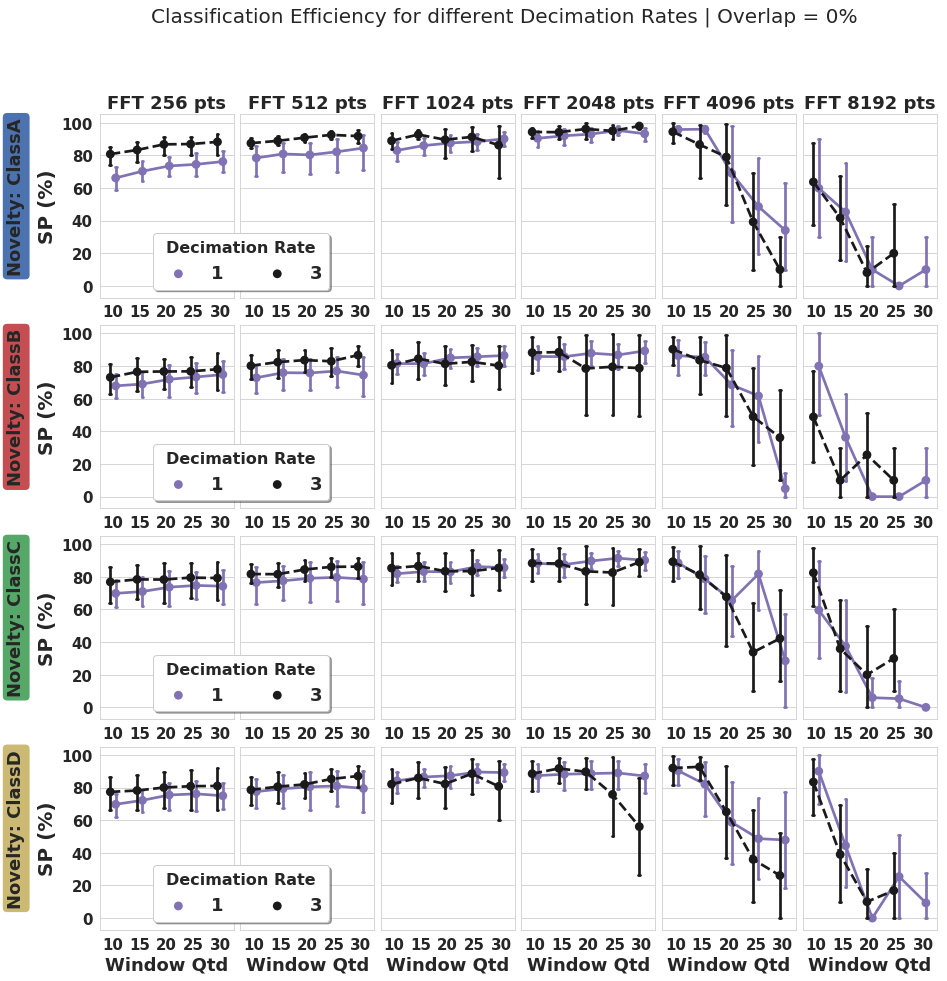

In [21]:
%matplotlib inline
qtd_list=[256, 512,1024,2048, 4096, 8192]; decimation=1; overlap=0
fig, axes = plt.subplots(figsize=(15,15), nrows=4, ncols=6, sharey=True)
for i, qtd in enumerate(qtd_list):
    for i_ax, ax in enumerate(axes[:,i]):
        nv = i_ax
        xs_results = df_results.xs(overlap, level='overlap', drop_level=True)\
                               .xs(qtd, level='window')\
                               .xs(nv, level='novelty')
        xs_results.reset_index(level=['Window Qtd', 'decimation'], drop=False, inplace=True)
        xs_results.drop(['eff_0', 'eff_1', 'eff_2'], axis=1, inplace=True)
        xs_results.loc[:, 'sp'] = 100*xs_results.loc[:, 'sp'].values
        sns.pointplot(x='Window Qtd', y='sp', hue='decimation', data=xs_results, 
                      #palette={0:'b', 1:'g', 2:'y', 4:'r'},
                      palette=['m', 'k'],
                      linestyles=['-', '--'],
                      capsize=0.07,
                      dodge=-0.2, ax=ax)
        if i_ax == 0:
            ax.set_title('FFT %i pts' % qtd, fontsize=18, weight='bold')
        if i_ax == 3:
            ax.set_xlabel('Window Qtd', fontsize=18, weight='bold')
        else:
            ax.set_xlabel('', fontsize=1, weight='bold')
        if i==0:
            ax.set_ylabel('SP (%)' , fontsize=20, weight='bold')
        else:
            ax.set_ylabel('' , fontsize=1, weight='bold')

        leg_handles = ax.get_legend_handles_labels()[0]
    #     ax.set_title('%i Spectres' % (i_qtd), fontsize=20)
        class_map = ['ClassA', 'ClassB', 'ClassC', 'ClassD']
        color_map = {0:'b',1:'r',2:'g',3:'y'}
        bbox_props = dict(boxstyle="round,pad=0.3", fc=color_map[nv], ec="w", lw=2)
        if i == 0:
            t = ax.text(-3.95, 55, "Novelty: %s" % class_map[nv], ha="left", va="center", rotation=90,
                        size=18,
                        bbox=bbox_props)

        if i == 1:
            legend = ax.legend(handles=leg_handles,
                               bbox_to_anchor=(0.8,-0.055),
                               ncol=2,
                               #labels=['3', '1'],
                               #mode="expand",
                               borderaxespad=1,
                               shadow=True,
                               frameon=True,
                               fancybox=True,
                               title='Decimation Rate',
                               fontsize=18,
                               loc='lower right')
            legend.get_title().set_fontsize(16)
        else:
            ax.get_legend().set_visible(False)
            
    fig.subplots_adjust(hspace=0.15, wspace=0.05)
    fig.suptitle('Classification Efficiency for different Decimation Rates | Overlap = 0%', fontsize=20);
fig.savefig('dec_run_256_8192.png', dpi = 300, bbox_inches='tight')

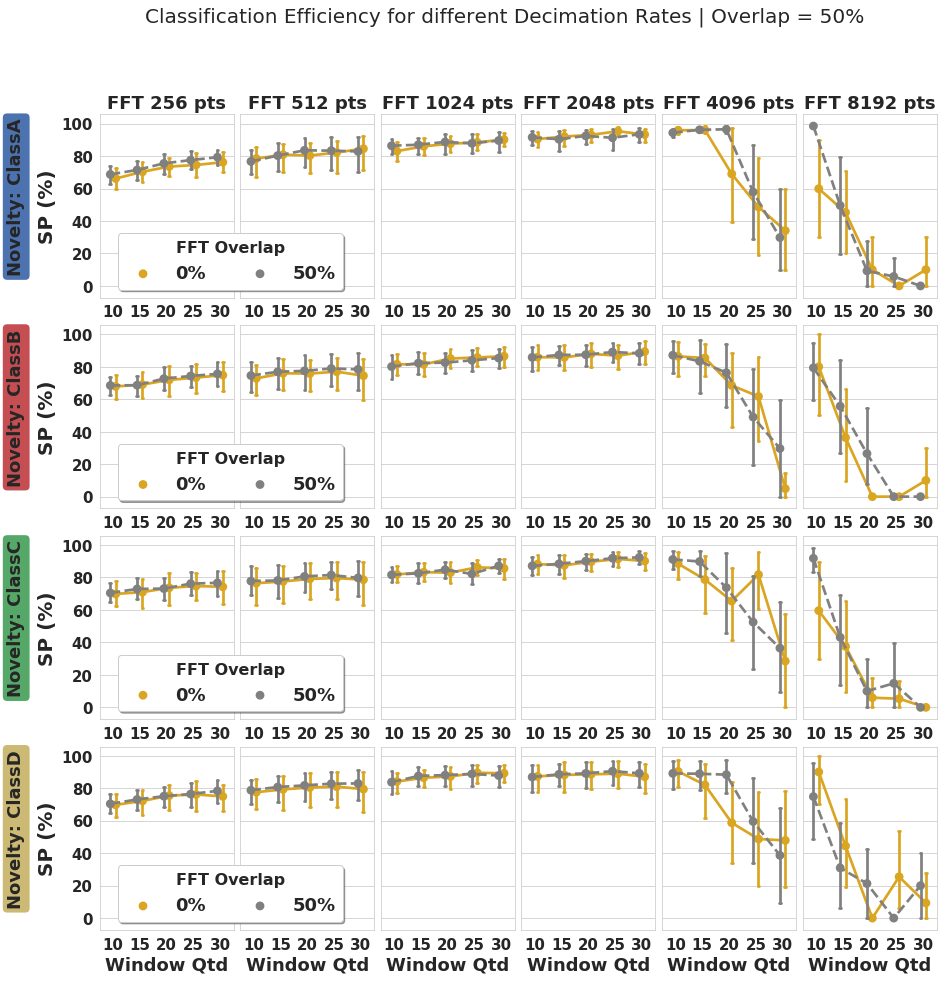

In [22]:
%matplotlib inline
qtd_list=[256, 512,1024,2048, 4096, 8192]; decimation=1; overlap=50
fig, axes = plt.subplots(figsize=(15,15), nrows=4, ncols=6, sharey=True)
for i, qtd in enumerate(qtd_list):
    for i_ax, ax in enumerate(axes[:,i]):
        nv = i_ax
        xs_results = df_results.xs(decimation, level='decimation', drop_level=True)\
                               .xs(qtd, level='window')\
                               .xs(nv, level='novelty')
        
        xs_results.reset_index(level=['Window Qtd', 'overlap'], drop=False, inplace=True)
        xs_results.drop(['eff_0', 'eff_1', 'eff_2'], axis=1, inplace=True)
        xs_results.loc[:, 'sp'] = 100*xs_results.loc[:, 'sp'].values
        
        sns.pointplot(x='Window Qtd', y='sp', hue='overlap', data=xs_results, 
                      #palette={0:'b', 1:'g', 2:'y', 4:'r'},
                      palette=['goldenrod', 'grey'],
                      linestyles=['-', '--'],
                      capsize=0.07,
                      dodge=-0.2, ax=ax)
        if i_ax == 0:
            ax.set_title('FFT %i pts' % qtd, fontsize=18, weight='bold')
        if i_ax == 3:
            ax.set_xlabel('Window Qtd', fontsize=18, weight='bold')
        else:
            ax.set_xlabel('', fontsize=1, weight='bold')
        if i==0:
            ax.set_ylabel('SP (%)' , fontsize=20, weight='bold')
        else:
            ax.set_ylabel('' , fontsize=1, weight='bold')

        leg_handles = ax.get_legend_handles_labels()[0]
    #     ax.set_title('%i Spectres' % (i_qtd), fontsize=20)
        class_map = ['ClassA', 'ClassB', 'ClassC', 'ClassD']
        color_map = {0:'b',1:'r',2:'g',3:'y'}
        bbox_props = dict(boxstyle="round,pad=0.3", fc=color_map[nv], ec="w", lw=2)
        if i == 0:
            t = ax.text(-3.95, 55, "Novelty: %s" % class_map[nv], ha="left", va="center", rotation=90,
                        size=18,
                        bbox=bbox_props)

        if i == 1:
            legend = ax.legend(handles=leg_handles,
                               bbox_to_anchor=(0.9,-0.055),
                               ncol=2,
                               labels=['0%', '50%'],
                               #mode="expand",
                               borderaxespad=1,
                               shadow=True,
                               frameon=True,
                               fancybox=True,
                               title='FFT Overlap',
                               fontsize=18,
                               loc='lower right')
            legend.get_title().set_fontsize(16)
        else:
            ax.get_legend().set_visible(False)
            
    fig.subplots_adjust(hspace=0.15, wspace=0.05)
    fig.suptitle('Classification Efficiency for different Decimation Rates | Overlap = 50%', fontsize=20);
fig.savefig('overlap_run_256_8192.png', dpi = 300, bbox_inches='tight')

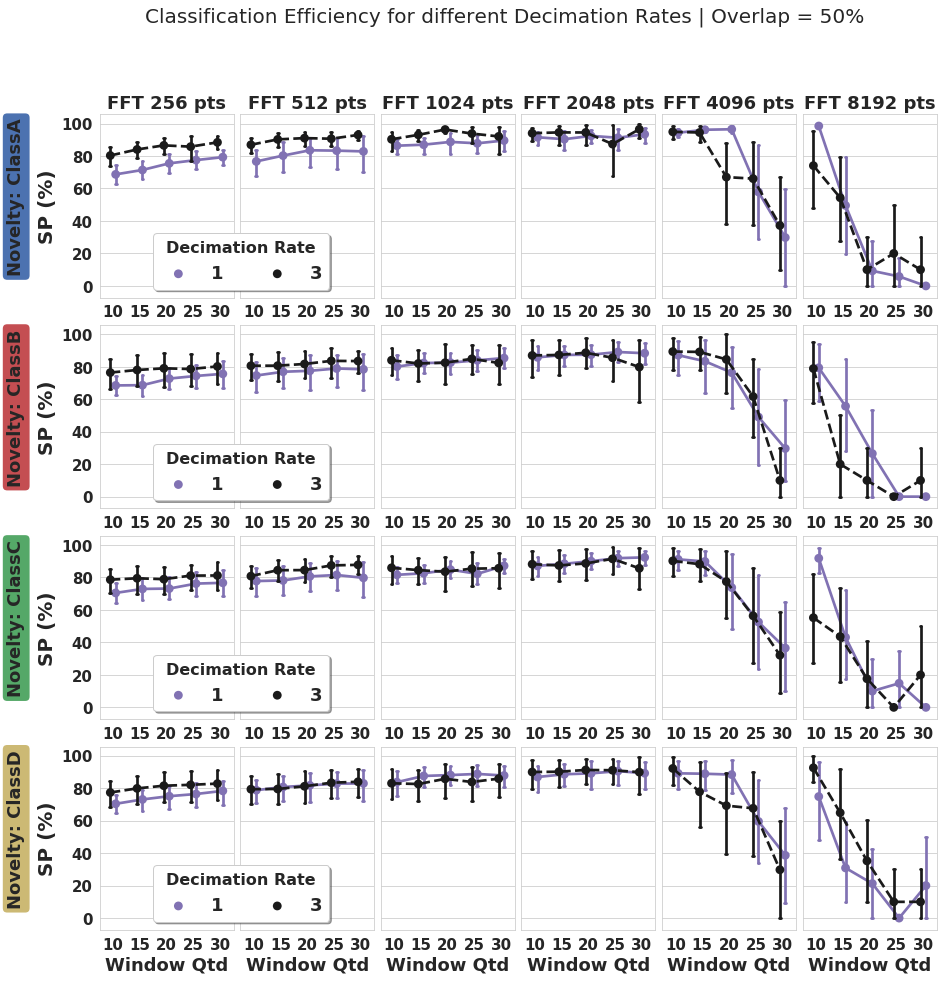

In [23]:
%matplotlib inline
qtd_list=[256, 512,1024,2048, 4096, 8192]; decimation=1; overlap=50
fig, axes = plt.subplots(figsize=(15,15), nrows=4, ncols=6, sharey=True)
for i, qtd in enumerate(qtd_list):
    for i_ax, ax in enumerate(axes[:,i]):
        nv = i_ax
        xs_results = df_results.xs(overlap, level='overlap', drop_level=True)\
                               .xs(qtd, level='window')\
                               .xs(nv, level='novelty')
        
        xs_results.reset_index(level=['Window Qtd', 'decimation'], drop=False, inplace=True)
        xs_results.drop(['eff_0', 'eff_1', 'eff_2'], axis=1, inplace=True)
        xs_results.loc[:, 'sp'] = 100*xs_results.loc[:, 'sp'].values
        
        sns.pointplot(x='Window Qtd', y='sp', hue='decimation', data=xs_results, 
                      #palette={0:'b', 1:'g', 2:'y', 4:'r'},
                      palette=['m', 'k'],
                      linestyles=['-', '--'],
                      capsize=0.07,
                      dodge=-0.2, ax=ax)
        if i_ax == 0:
            ax.set_title('FFT %i pts' % qtd, fontsize=18, weight='bold')
        if i_ax == 3:
            ax.set_xlabel('Window Qtd', fontsize=18, weight='bold')
        else:
            ax.set_xlabel('', fontsize=1, weight='bold')
        if i==0:
            ax.set_ylabel('SP (%)' , fontsize=20, weight='bold')
        else:
            ax.set_ylabel('' , fontsize=1, weight='bold')

        leg_handles = ax.get_legend_handles_labels()[0]
    #     ax.set_title('%i Spectres' % (i_qtd), fontsize=20)
        class_map = ['ClassA', 'ClassB', 'ClassC', 'ClassD']
        color_map = {0:'b',1:'r',2:'g',3:'y'}
        bbox_props = dict(boxstyle="round,pad=0.3", fc=color_map[nv], ec="w", lw=2)
        if i == 0:
            t = ax.text(-3.95, 55, "Novelty: %s" % class_map[nv], ha="left", va="center", rotation=90,
                        size=18,
                        bbox=bbox_props)

        if i == 1:
            legend = ax.legend(handles=leg_handles,
                               bbox_to_anchor=(0.8,-0.055),
                               ncol=2,
                               #labels=['3', '1'],
                               #mode="expand",
                               borderaxespad=1,
                               shadow=True,
                               frameon=True,
                               fancybox=True,
                               title='Decimation Rate',
                               fontsize=18,
                               loc='lower right')
            legend.get_title().set_fontsize(16)
        else:
            ax.get_legend().set_visible(False)
            
    fig.subplots_adjust(hspace=0.15, wspace=0.05)
    fig.suptitle('Classification Efficiency for different Decimation Rates | Overlap = 50%', fontsize=20);
fig.savefig('overlap_dec_run_256_8192.png', dpi = 300, bbox_inches='tight')

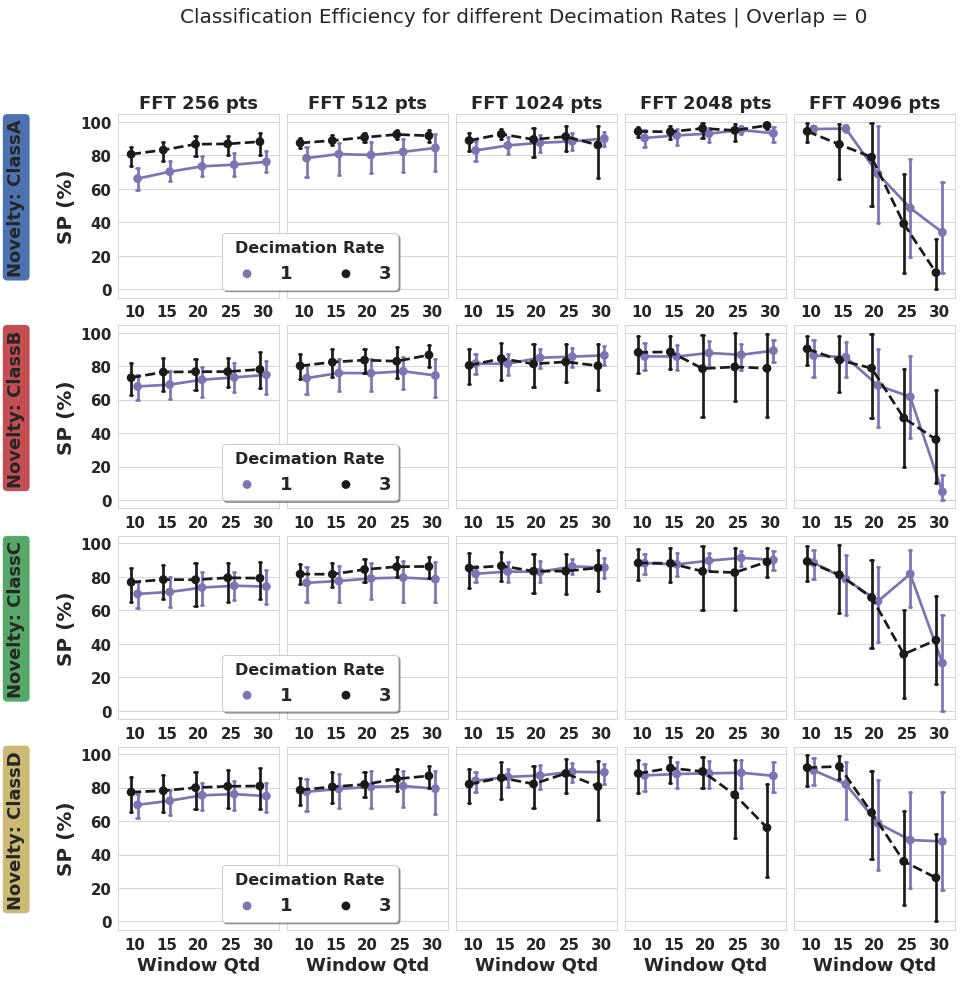

In [24]:
%matplotlib inline
qtd_list=[256, 512,1024,2048, 4096]; decimation=1; overlap=0
fig, axes = plt.subplots(figsize=(15,15), nrows=4, ncols=5, sharey=True)
for i, qtd in enumerate(qtd_list):
    for i_ax, ax in enumerate(axes[:,i]):
        nv = i_ax
        xs_results = df_results.xs(overlap, level='overlap', drop_level=True)\
                               .xs(qtd, level='window')\
                               .xs(nv, level='novelty')
        xs_results.reset_index(level=['Window Qtd', 'decimation'], drop=False, inplace=True)
        xs_results.drop(['eff_0', 'eff_1', 'eff_2'], axis=1, inplace=True)
        xs_results.loc[:, 'sp'] = 100*xs_results.loc[:, 'sp'].values
        sns.pointplot(x='Window Qtd', y='sp', hue='decimation', data=xs_results, 
                      #palette={0:'b', 1:'g', 2:'y', 4:'r'},
                      palette=['m', 'k'],
                      linestyles=['-', '--'],
                      capsize=0.07,
                      dodge=-0.2, ax=ax)
        if i_ax == 0:
            ax.set_title('FFT %i pts' % qtd, fontsize=18, weight='bold')
        if i_ax == 3:
            ax.set_xlabel('Window Qtd', fontsize=18, weight='bold')
        else:
            ax.set_xlabel('', fontsize=1, weight='bold')
        if i==0:
            ax.set_ylabel('SP (%)' , fontsize=20, weight='bold')
        else:
            ax.set_ylabel('' , fontsize=1, weight='bold')

        leg_handles = ax.get_legend_handles_labels()[0]
    #     ax.set_title('%i Spectres' % (i_qtd), fontsize=20)
        class_map = ['ClassA', 'ClassB', 'ClassC', 'ClassD']
        color_map = {0:'b',1:'r',2:'g',3:'y'}
        bbox_props = dict(boxstyle="round,pad=0.3", fc=color_map[nv], ec="w", lw=2)
        if i == 0:
            t = ax.text(-3.95, 55, "Novelty: %s" % class_map[nv], ha="left", va="center", rotation=90,
                        size=18,
                        bbox=bbox_props)

        if i == 1:
            legend = ax.legend(handles=leg_handles,
                               bbox_to_anchor=(0.8,-0.055),
                               ncol=2,
                               #labels=['3', '1'],
                               #mode="expand",
                               borderaxespad=1,
                               shadow=True,
                               frameon=True,
                               fancybox=True,
                               title='Decimation Rate',
                               fontsize=18,
                               loc='lower right')
            legend.get_title().set_fontsize(16)
        else:
            ax.get_legend().set_visible(False)
            
    fig.subplots_adjust(hspace=0.15, wspace=0.05)
    fig.suptitle('Classification Efficiency for different Decimation Rates | Overlap = 0', fontsize=20);
fig.savefig('dec_run_256_4096.png', dpi = 300, bbox_inches='tight')

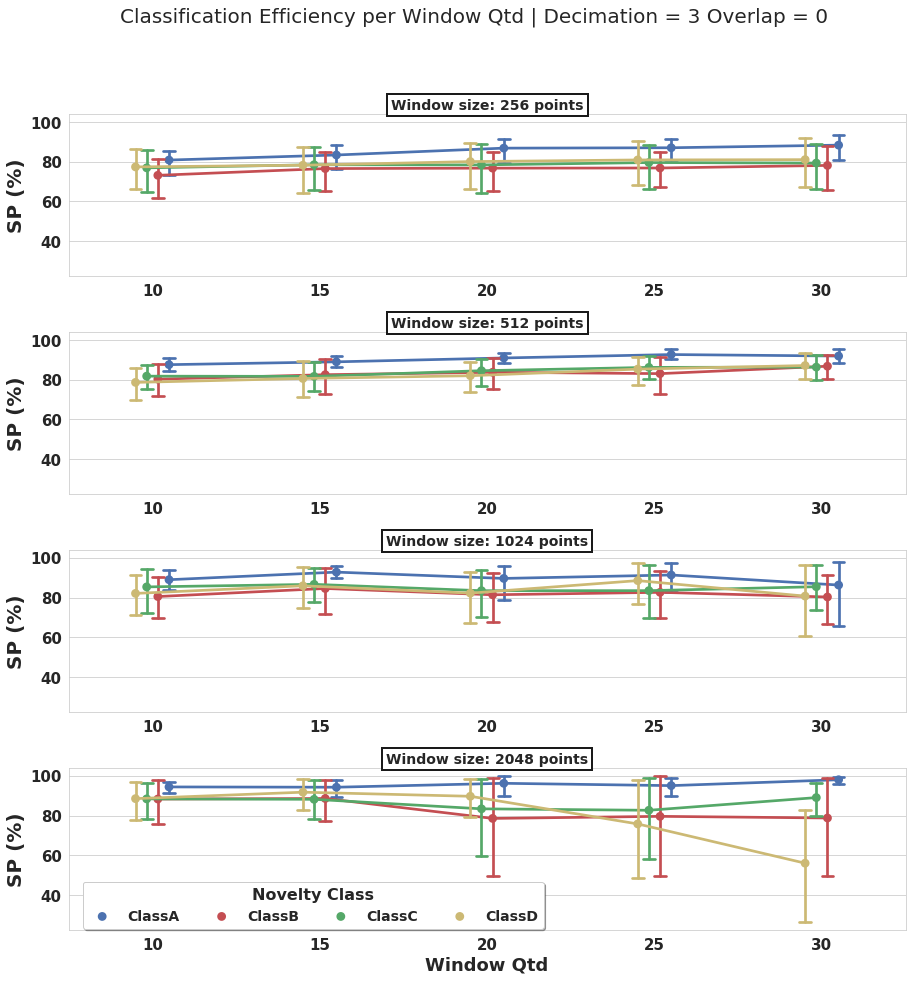

In [221]:
%matplotlib inline
qtd=256; decimation=3; overlap=0
fig, axes = plt.subplots(figsize=(15,15), nrows=4, ncols=1, sharey=True)

for i_ax, ax in enumerate(axes.flatten()):
    i_qtd = pow(2,i_ax)*qtd
    xs_results = df_results.xs(decimation, level='decimation')\
                           .xs(overlap, level='overlap', drop_level=True)\
                           .xs(i_qtd, level='window')
    xs_results.reset_index(level=['Window Qtd', 'novelty'], drop=False, inplace=True)
    xs_results.drop(['eff_0', 'eff_1', 'eff_2'], axis=1, inplace=True)
    xs_results.loc[:, 'sp'] = 100*xs_results.loc[:, 'sp'].values
    sns.pointplot(x='Window Qtd', y='sp', hue='novelty', data=xs_results, 
                  #palette={0:'b', 1:'g', 2:'y', 4:'r'},
                  palette=['b', 'r', 'g', 'y'],
                  capsize=0.07,
                  dodge=-0.2, ax=ax)
    if i_ax == 3:
        ax.set_xlabel('Window Qtd', fontsize=18, weight='bold')
    else:
        ax.set_xlabel('', fontsize=1, weight='bold')
    ax.set_ylabel('SP (%)', fontsize=20, weight='bold')

    leg_handles = ax.get_legend_handles_labels()[0]
#     ax.set_title('%i Spectres' % (i_qtd), fontsize=20)
    
    bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="k", lw=2)
    t = ax.text(2.0, 105, "Window size: %i points" % i_qtd, ha="center", va="bottom", 
                size=14,
                bbox=bbox_props)
    
    if i_ax == 3:
        legend = ax.legend(handles=leg_handles,
                           bbox_to_anchor=(0,-0.08),
                           ncol=4,
                           labels=['ClassA', 'ClassB', 'ClassC', 'ClassD'],
                           #mode="expand",
                           borderaxespad=1.0,
                           shadow=True,
                           frameon=True,
                           fancybox=True,
                           title='Novelty Class',
                           fontsize=14,
                           loc='lower left')
        legend.get_title().set_fontsize(16)
    else:
        ax.get_legend().set_visible(False)
fig.subplots_adjust(hspace=0.35)
fig.suptitle('Classification Efficiency per Window Qtd |' 
             ' Decimation = %i Overlap = %i' % (decimation, overlap), fontsize=20);

### Decimation: 3 Overlap: 0% 

### Decimation: 3 Overlap: 0% 

### Decimation: 3 Overlap: 50% 

### Decimation: 1 Overlap: 50% 

In [11]:
#summary_results = df_results[df_results['Window Qtd'].isin([10, 20, 30])]
summary_results = df_results.drop('decimation', axis=1)
# x = sns.factorplot(x='window', y = 'sp', hue='novelty', col='Window Qtd', col_wrap=3,#row='decimation', 
#                    palette=['b', 'r', 'g', 'y'],
#                    data=summary_results, kind='bar')
